In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import os
import re
import pandas as pd
from unidecode import unidecode
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Carga de datasets

In [12]:
ruta = r"C:/Users/rhernandez/OneDrive - Generando Soluciones Anlalíticas S.A/Documents/New folder/Proyecto_Fase_2/datasets"
archivos = [os.path.join(ruta, f) for f in os.listdir(ruta) if f.endswith(".xlsx")]

dfs = {}

for archivo in archivos:
    base = os.path.basename(archivo)
    match = re.search(r"\d{4}", base)
    if match:
        anio = match.group()
        df = pd.read_excel(archivo)
        dfs[f"df_{anio}"] = df

for year in range(2020, 2024 + 1):
    name = f"df_{year}"
    if name in dfs:
        df = dfs[name]

        df.columns = [unidecode(c).lower() for c in df.columns]

        df.columns = [re.sub(r"gran_grupos|gran_grupos", "gran_grupos", c) for c in df.columns]
        df.columns = [re.sub(r"subg_primarios|subg_principales", "subg_principales", c) for c in df.columns]
        df.columns = [re.sub(r"g_primarios", "g_primarios", c) for c in df.columns]

        df = df.drop(columns=["edad_quinquenales", "ocupacionhabitual", "filter_$"], errors="ignore")

        if "area_geo_inf" in df.columns:
            df["area_geo_inf"] = df["area_geo_inf"].astype(str)

        dfs[name] = df

df_final = pd.concat([dfs[f"df_{y}"] for y in range(2020, 2024 + 1)], ignore_index=True)
df_final = df_final.drop(columns=["num_corre"], errors="ignore")
df_final["area_geo_inf"] = pd.to_numeric(df_final["area_geo_inf"], errors="coerce")
df_final.head()


,depto_boleta,muni_boleta,mes_boleta,ano_boleta,falta_inf,sexo_inf,edad_inf,grupo_etnico_inf,est_conyugal_inf,nacimiento_inf,...,niv_escolaridad_inf,est_ebriedad_inf,area_geo_inf,depto_nacimiento_inf,nacionalidad_inf,g_edad_80ymas,g_edad_60ymas,subg_principales,gran_grupos,g_primarios
0,1,102,1,2020,3,1,29,2,1,101,...,4,1,2,1,1,4,4,971,12,NaN
1,1,102,1,2020,3,1,19,2,1,101,...,3,1,2,1,1,2,2,94,9,NaN
2,1,102,1,2020,4,1,19,2,1,101,...,3,1,2,1,1,2,2,94,9,NaN
3,1,102,1,2020,3,1,22,2,1,101,...,3,1,2,1,1,3,3,31,3,NaN
4,1,102,1,2020,4,1,22,2,1,101,...,3,1,2,1,1,3,3,31,3,NaN


In [32]:
#df_final_bk = df_final.copy()
df_final = df_final_bk.copy()

In [33]:
df_final = df_final[df_final["area_geo_inf"] != 9].copy()
df_final["area_geo_inf"] = df_final["area_geo_inf"] - 1

In [34]:
df_final = df_final.sample(frac = 1, random_state=42).reset_index(drop = True)

In [35]:
X = df_final[['depto_boleta','sexo_inf', 'edad_inf', 'grupo_etnico_inf','est_conyugal_inf','cond_alfabetismo_inf', 'niv_escolaridad_inf','falta_inf','est_ebriedad_inf']]
y = df_final['area_geo_inf']

In [44]:
y.unique()

array([0, 1], dtype=int64)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model = Sequential()
model.add(Dense(32, input_dim=9, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

c:\Users\rhernandez\Anaconda3\envs\agentes\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [47]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [53]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6873 - loss: 0.5777 - val_accuracy: 0.6897 - val_loss: 0.5780
Epoch 2/50
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6859 - loss: 0.5779 - val_accuracy: 0.6869 - val_loss: 0.5790
Epoch 3/50
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6868 - loss: 0.5776 - val_accuracy: 0.6852 - val_loss: 0.5813
Epoch 4/50
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6865 - loss: 0.5775 - val_accuracy: 0.6878 - val_loss: 0.5784


In [54]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

820/820 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6897 - loss: 0.5780
Loss: 0.5780359506607056, Accuracy: 0.689723551273346


820/820 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step


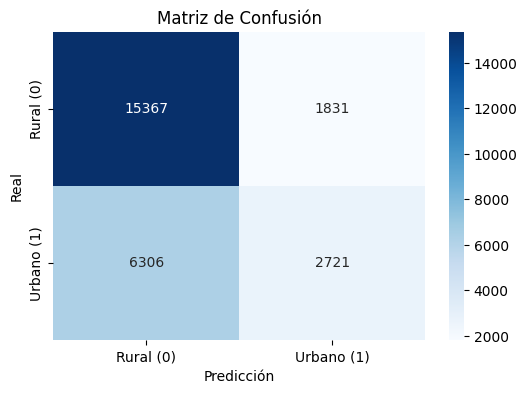


> Reporte de clasificación:

              precision    recall  f1-score   support

           0     0.7090    0.8935    0.7907     17198
           1     0.5978    0.3014    0.4008      9027

    accuracy                         0.6897     26225
   macro avg     0.6534    0.5975    0.5957     26225
weighted avg     0.6707    0.6897    0.6565     26225



In [58]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Rural (0)", "Urbano (1)"],
            yticklabels=["Rural (0)", "Urbano (1)"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print("\n> Reporte de clasificación:\n")
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
personas_rd_1_1 = np.array([[1,30,2]])
res = model.predict(personas_rd_1_1)
print(res)